In [215]:
from alpha_vantage.timeseries import TimeSeries
import json
import pandas as pd
from sklearn import preprocessing
import numpy as np

In [304]:
data = pd.read_csv('CPALL.csv')
data = data.dropna()
data = data[data['Vol.'] != '-'] # drop the rows which contain '-' value
data['Vol.'] = data['Vol.'].replace({'M':'*1e6', 'K': '*1e3'}, regex=True).map(pd.eval).astype(int)
data['Change %'] = data['Change %'].replace({'%':'*1'}, regex=True).map(pd.eval).astype(float)
data.drop('Date', axis=1, inplace = True)
data = data.drop(0, axis=0)
data.sort_index(ascending=False, inplace = True, ignore_index=True)
data.head(10)

,Price,Open,High,Low,Vol.,Change %
0,3.17,3.15,3.17,3.12,905800,0.63
1,3.23,3.15,3.30,3.15,5010000,1.89
2,3.10,3.25,3.27,3.08,4620000,-4.02
3,3.12,3.10,3.20,3.10,2040000,0.65
4,3.08,3.05,3.10,3.05,7900000,-1.28
5,3.05,3.10,3.12,3.05,1090000,-0.97
6,2.98,3.10,3.10,2.98,11270000,-2.30
7,2.92,2.95,3.02,2.90,6420000,-2.01
8,2.92,2.92,3.02,2.92,11780000,0.00
9,2.98,2.92,2.98,2.92,7300000,2.05


In [305]:
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)
history_points = 200
ohlcv_histories_normalised = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.array([data_normalised[:,1][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

In [306]:
data = np.asanyarray(data)
next_day_open_values = np.array([data[:,1][i + history_points].copy() for i in range(len(data) - history_points)])

In [307]:
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(np.expand_dims(next_day_open_values, axis=-1))
# y_normaliser.transform(next_day_open_values) # Indicate the values

MinMaxScaler()

In [308]:
test_split = 0.8
n = int(ohlcv_histories_normalised.shape[0] * test_split)

In [309]:
ohlcv_train = ohlcv_histories_normalised[:n]
y_train = next_day_open_values_normalised[:n]
ohlcv_test = ohlcv_histories_normalised[n:]
y_test = next_day_open_values_normalised[n:]

unscaled_y_test = next_day_open_values[n:]

In [310]:
ohlcv_train.shape

(2516, 200, 6)

In [311]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
# from tensorflow import set_random_seed
# set_random_seed(4)
import tensorflow
tensorflow.random.set_seed(4)
# Solve pydot problems
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

lstm_input = Input(shape=(history_points, 6), name='lstm_input')
x = LSTM(200, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [312]:
model.fit(x=ohlcv_train, y=y_train, batch_size=64, epochs=100, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(ohlcv_test, y_test)
print(evaluation)

Epoch 1/100
36/36 [==============================] - 8s 227ms/step - loss: 0.0215 - val_loss: 7.6447e-04
Epoch 2/100
36/36 [==============================] - 8s 215ms/step - loss: 6.6972e-04 - val_loss: 7.1201e-04
Epoch 3/100
36/36 [==============================] - 8s 214ms/step - loss: 5.0278e-04 - val_loss: 7.4646e-04
Epoch 4/100
36/36 [==============================] - 8s 217ms/step - loss: 4.8729e-04 - val_loss: 6.1667e-04
Epoch 5/100
36/36 [==============================] - 8s 219ms/step - loss: 4.9880e-04 - val_loss: 6.6522e-04
Epoch 6/100
36/36 [==============================] - 8s 221ms/step - loss: 4.4368e-04 - val_loss: 6.1447e-04
Epoch 7/100
36/36 [==============================] - 8s 224ms/step - loss: 4.2677e-04 - val_loss: 2.5431e-04
Epoch 8/100
36/36 [==============================] - 8s 223ms/step - loss: 4.5190e-04 - val_loss: 5.6116e-04
Epoch 9/100
36/36 [==============================] - 8s 226ms/step - loss: 4.1309e-04 - val_loss: 5.8517e-04
Epoch 10/100
36/36 [===

36/36 [==============================] - 10s 290ms/step - loss: 1.0056e-04 - val_loss: 1.7664e-05
Epoch 76/100
36/36 [==============================] - 11s 294ms/step - loss: 8.9642e-05 - val_loss: 1.0913e-04
Epoch 77/100
36/36 [==============================] - 11s 307ms/step - loss: 8.9502e-05 - val_loss: 4.8247e-05
Epoch 78/100
36/36 [==============================] - 11s 297ms/step - loss: 9.5920e-05 - val_loss: 3.4881e-04
Epoch 79/100
36/36 [==============================] - 11s 310ms/step - loss: 1.1554e-04 - val_loss: 6.6262e-05
Epoch 80/100
36/36 [==============================] - 11s 293ms/step - loss: 8.2281e-05 - val_loss: 1.1745e-04
Epoch 81/100
36/36 [==============================] - 10s 288ms/step - loss: 9.4753e-05 - val_loss: 1.7739e-05
Epoch 82/100
36/36 [==============================] - 11s 295ms/step - loss: 9.0661e-05 - val_loss: 2.5270e-05
Epoch 83/100
36/36 [==============================] - 11s 292ms/step - loss: 8.6481e-05 - val_loss: 2.5292e-04
Epoch 84/100
3

In [314]:
y_test_predicted = model.predict(ohlcv_test) # model.predict returns normalised values
# now we scale them back using the y_scaler from before
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(ohlcv_histories_normalised) # ENTIRE DATASET
y_predicted = y_normaliser.inverse_transform(y_predicted)

In [315]:
unscaled_y_test = np.expand_dims(unscaled_y_test, -1)
unscaled_y_test

array([[79.  ],
       [79.75],
       [78.5 ],
       [78.5 ],
       [78.5 ],
       [79.5 ],
       [79.75],
       [80.5 ],
       [83.  ],
       [83.75],
       [83.75],
       [83.75],
       [84.5 ],
       [84.  ],
       [84.25],
       [82.75],
       [84.  ],
       [84.75],
       [87.  ],
       [86.25],
       [86.  ],
       [86.5 ],
       [87.25],
       [87.5 ],
       [87.  ],
       [87.  ],
       [86.75],
       [87.5 ],
       [87.  ],
       [87.75],
       [88.  ],
       [87.5 ],
       [88.5 ],
       [88.5 ],
       [89.  ],
       [87.  ],
       [87.25],
       [87.5 ],
       [87.  ],
       [88.  ],
       [87.5 ],
       [87.5 ],
       [87.5 ],
       [86.75],
       [87.  ],
       [86.5 ],
       [84.  ],
       [86.  ],
       [87.  ],
       [87.  ],
       [87.  ],
       [86.5 ],
       [87.  ],
       [86.25],
       [87.  ],
       [87.  ],
       [88.  ],
       [88.  ],
       [88.  ],
       [88.  ],
       [87.5 ],
       [87.  ],
       [

In [316]:
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

6.549596617532566


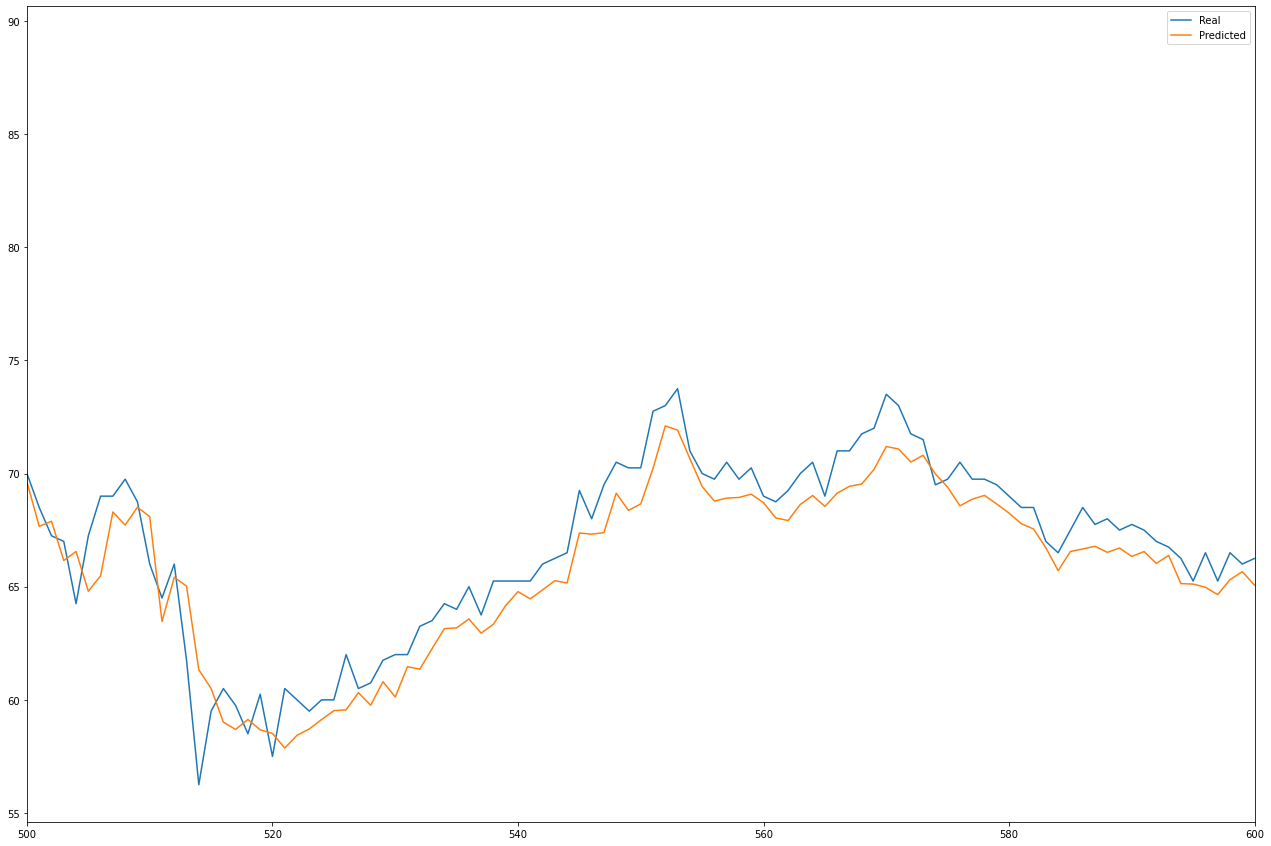

In [319]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.xlim([500, 600]) 
# plt.ylim([60, 75]) 
plt.show()

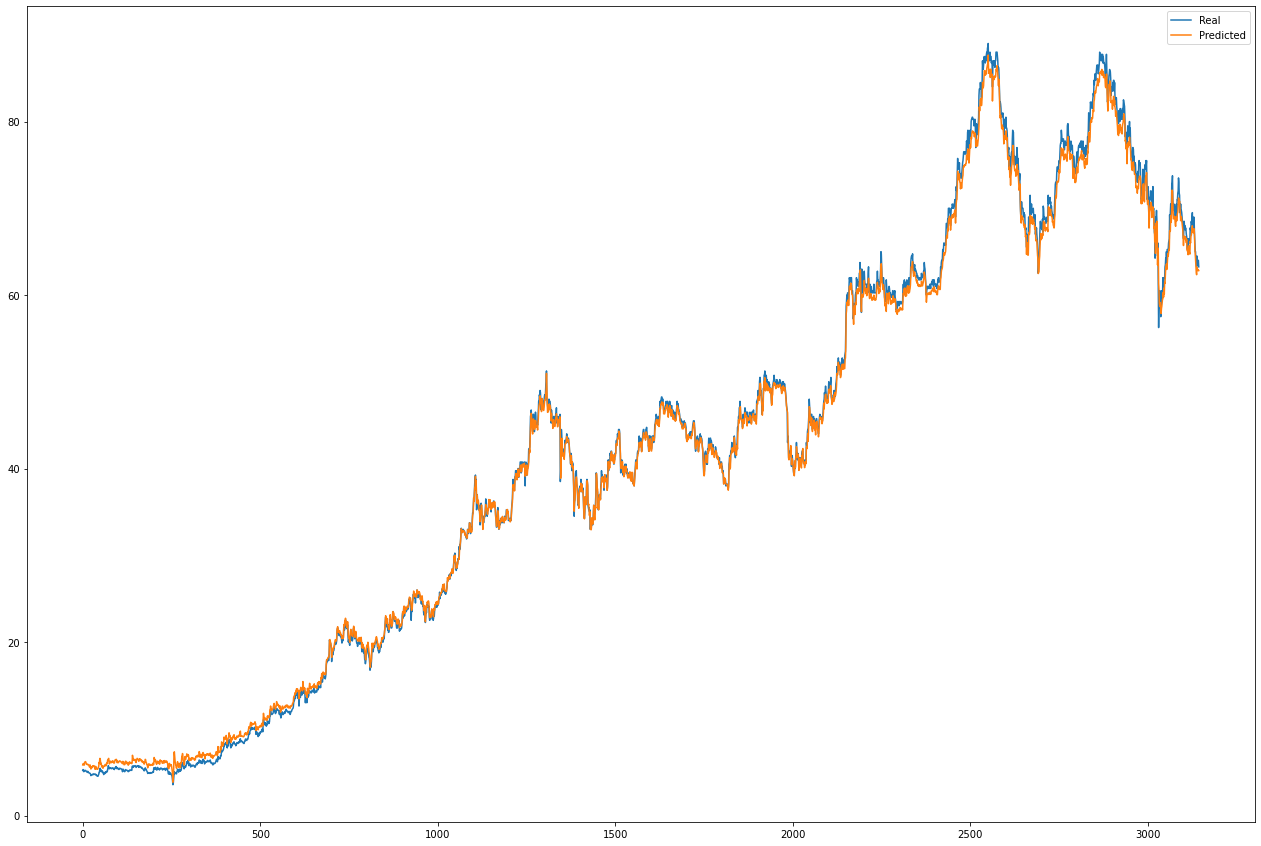

In [320]:
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(next_day_open_values[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()